# Import section

In [1]:
import numpy as np
import pandas as pd 
import os
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers,optimizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import warnings

warnings.filterwarnings('ignore')

# Load dataset 

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
X = np.load("./Dataset/Digits/X.npy")
y = np.load("./Dataset/Digits/Y.npy")

In [4]:
def correct_class_data(y):
    corrected_list = []
    for vec in y:
        corrected_vec = [0]*10
        corrected_vec[label_map[vec.tolist().index(1.0)]] = 1.0
        corrected_list.append(corrected_vec)
    return np.array(corrected_list)

In [5]:
X = np.expand_dims(X, axis=3)

In [6]:
label_map = {0:9, 1:0, 2:7, 3:6, 4:1, 5:8, 6:4, 7:3, 8:2, 9:5}

y = correct_class_data(y)

In [7]:
number_of_classes = 10
epoch_number = 100

In [8]:
print(X.shape)
print(y.shape)

(2062, 64, 64, 1)
(2062, 10)


In [9]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

 Dataset description:
- Image size: 64x64
- Color space: Grayscale
- File format: npy
- Number of classes: 10 (Digits: 0-9)
- Number of participant students: 218
- Number of samples per student: 10

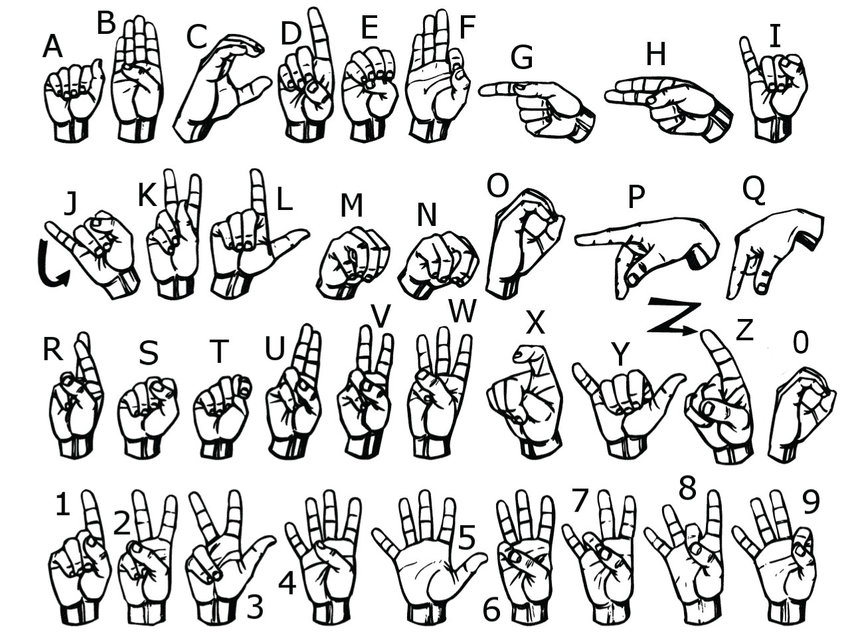

Distribution

In [10]:
#label_map = {0:'9', 1:'0', 2:'7', 3:'6', 4:'1', 5:'8', 6:'4', 7:'3', 8:'2', 9:'5'}
y_int = [label_map[x.tolist().index(1.0)] for x in y.astype(np.int)] 

unique, counts = np.unique(np.array(y_int), return_counts=True)

y_counts_dict = dict(zip(unique, counts))

In [11]:
y_counts_dict

{0: 206,
 1: 207,
 2: 208,
 3: 206,
 4: 207,
 5: 204,
 6: 206,
 7: 206,
 8: 207,
 9: 205}

In [12]:

#y_int
#counts


<AxesSubplot: >

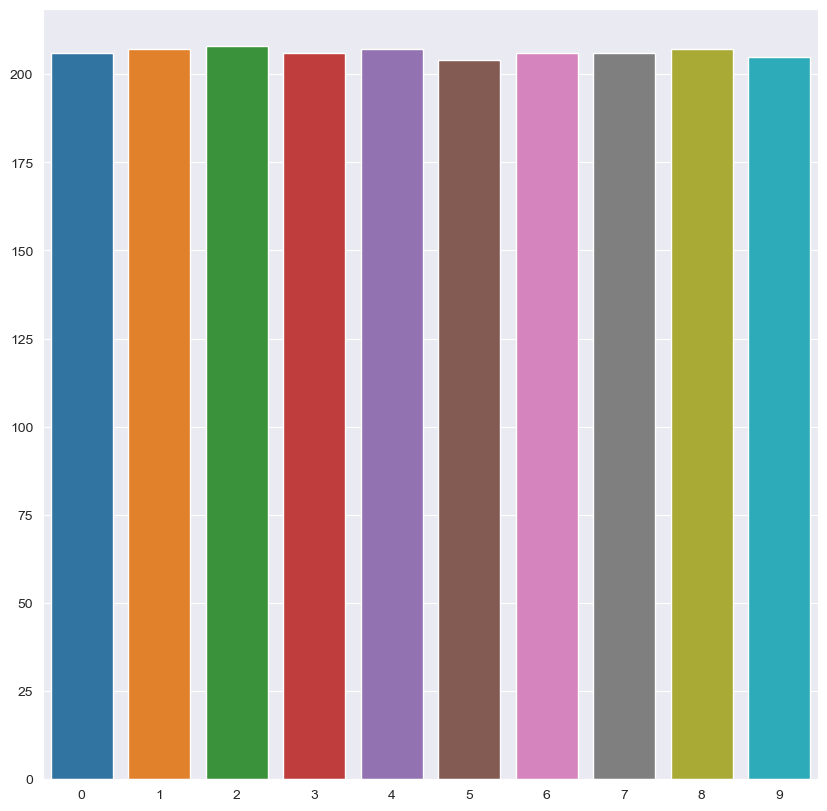

In [13]:
plt.figure(figsize = (10,10)) # Label Count
sns.set_style("darkgrid")
sns.barplot(pd.DataFrame({"digit":counts}).T)

In [14]:
def display_data(images, labels, n=10):
    y_int = np.array(labels)
    fig, axarr=plt.subplots(nrows=n, ncols=n, figsize=(18, 18))
    axarr=axarr.flatten()
    plt_id=0
    start_index=0
    for sign in range(10):
        sign_indexes=np.where(y_int==sign)[0]
        for i in range(n):

            image_index=sign_indexes[i]
            axarr[plt_id].imshow(images[image_index], cmap='gray')
            axarr[plt_id].set_xticks([])
            axarr[plt_id].set_yticks([])
            axarr[plt_id].set_title("Sign :{}".format(sign))
            plt_id=plt_id+1
    plt.suptitle("{} Sample for Each Classes".format(n))
    plt.show()

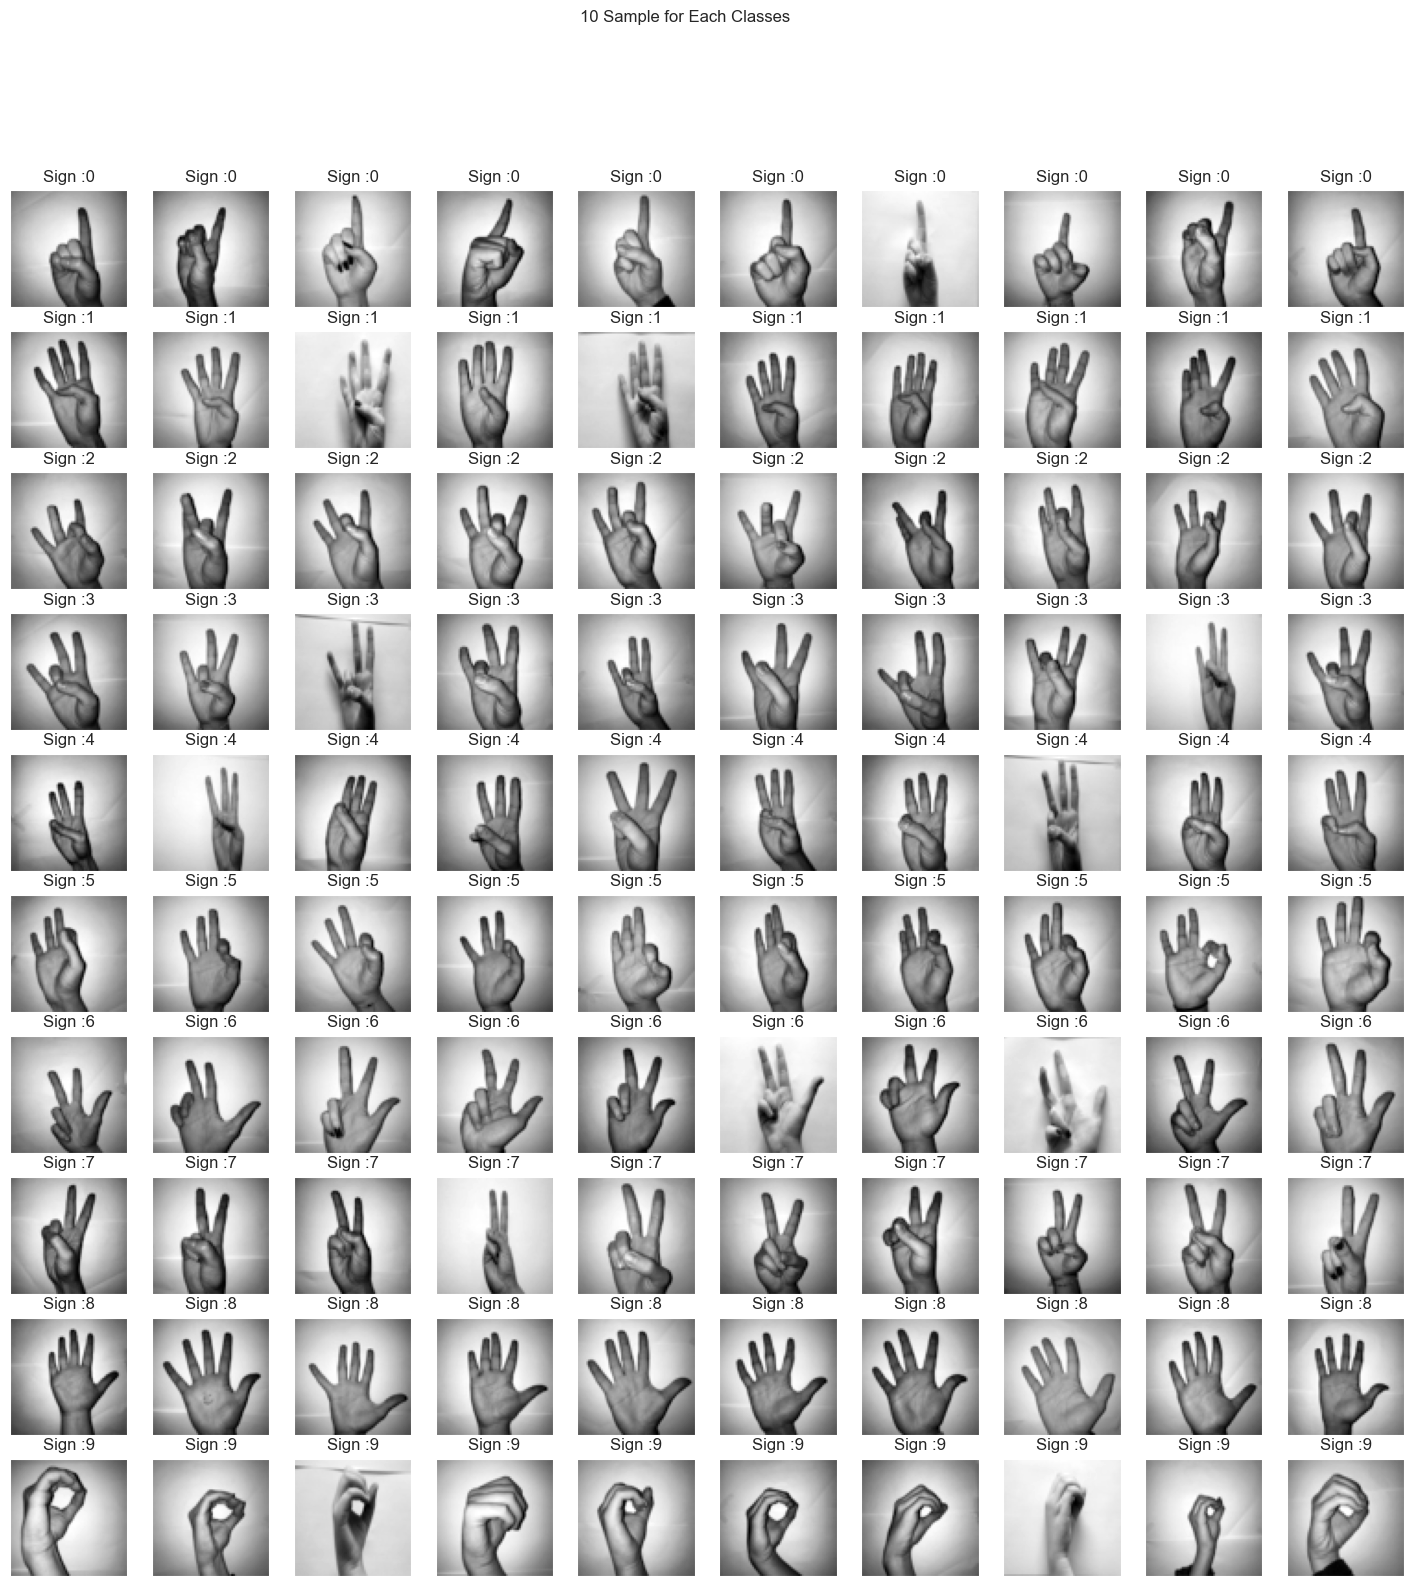

In [15]:
display_data(X, y_int)

# Model creation

## Split data

In [16]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
print(X_train.shape)
print(y_train.shape)

(1443, 64, 64, 1)
(1443, 10)


## Data Augmentation

In [18]:
X_aug = np.copy(X)

augmented_data = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


augmented_data.fit(X_aug)

In [19]:
X_aug.shape

(2062, 64, 64, 1)

In [20]:
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_aug, y, stratify=y, test_size=0.3, random_state=42)

In [21]:
def plot_loss_accuracy_curves(history, model_name):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  plt.suptitle(" Convulutional Model {} Loss and Accuracy in Train and Validation Datasets".format(model_name))
    
  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [22]:
def evaluate_conv_model(model, model_name, X_train, y_train, X_test, y_test, epochs = epoch_number,
                        optimizer=optimizers.RMSprop(lr=0.0001), callbacks=None, loss="categorical_crossentropy"):
    print("[INFO]:Convolutional Model {} created...".format(model_name))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    print("[INFO]:Convolutional Model {} compiled...".format(model_name))
    
    print("[INFO]:Convolutional Model {} training....".format(model_name))
    #earlyStopping = EarlyStopping(monitor = 'val_loss', patience=20, verbose = 1) 
    #if callbacks is None:
    #    callbacks = [earlyStopping]
    model.summary()
    history=model.fit(X_train, y_train, 
             validation_data=(X_test, y_test),
             epochs=epochs,
            callbacks=callbacks,
            )
    print("[INFO]:Convolutional Model {} trained....".format(model_name))

    test_scores=model.evaluate(X_test, y_test, verbose=0)
    train_scores=model.evaluate(X_train, y_train, verbose=0)
    print("[INFO]:Train Accuracy:{:.3f}".format(train_scores[1]))
    print("[INFO]:Validation Accuracy:{:.3f}".format(test_scores[1]))

    plot_loss_accuracy_curves(history, model_name)
    return model

In [23]:
def display_confusion_matrix(true, predicted):
    cfm_result = confusion_matrix(true, predicted, normalize="pred")
    classes = [str(i) for i in range(10)]
    df_cfm = pd.DataFrame(cfm_result, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sns.heatmap(df_cfm, annot=True,cmap=plt.cm.Blues)

## Model 1

In [24]:
model1=Sequential()
model1.add(layers.Conv2D(64, kernel_size=(3,3),
                       padding="same",
                       activation="relu", 
                       input_shape=(64, 64,1)))
model1.add(layers.MaxPooling2D((2,2)))

model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation="relu"))
model1.add(layers.Dense(number_of_classes, activation="softmax"))

#model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])


[INFO]:Convolutional Model Model 1 created...
[INFO]:Convolutional Model Model 1 compiled...
[INFO]:Convolutional Model Model 1 training....
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 128)               8388736   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                               

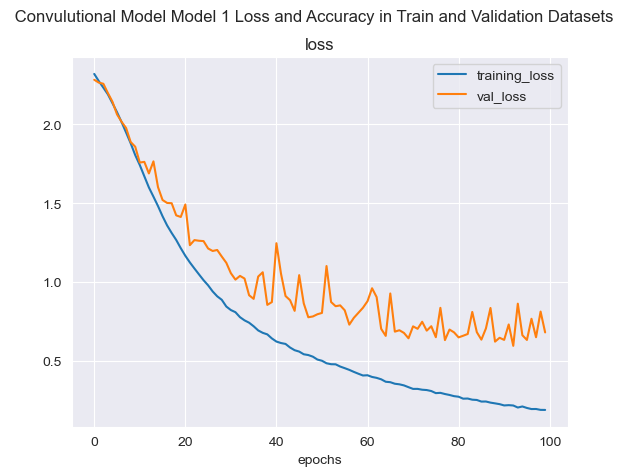

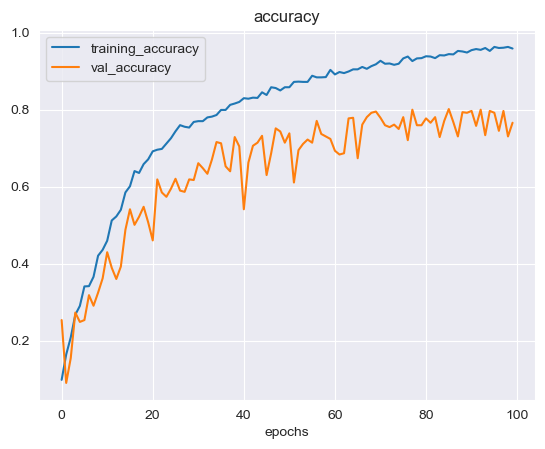

In [25]:
evaluate_conv_model(model1, "Model 1", X_train, y_train, X_test, y_test, epochs = epoch_number)

20/20 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

           0    0.93548   0.82857   0.87879        70
           1    0.84906   0.86538   0.85714        52
           2    0.73134   0.81667   0.77165        60
           3    0.86765   0.95161   0.90769        62
           4    0.44697   0.90769   0.59898        65
           5    0.84848   0.91803   0.88189        61
           6    0.90323   0.44444   0.59574        63
           7    0.83673   0.53947   0.65600        76
           8    0.80000   0.65455   0.72000        55
           9    0.93478   0.78182   0.85149        55

    accuracy                        0.76575       619
   macro avg    0.81537   0.77082   0.77194       619
weighted avg    0.81426   0.76575   0.76771       619



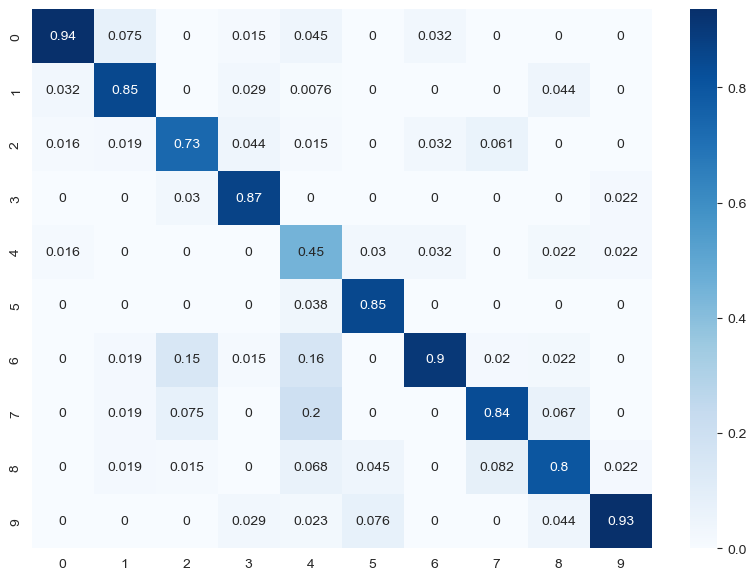

In [61]:
y_pred = model1.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)
print(classification_report(target_test,pred,digits=5))
display_confusion_matrix(target_test, pred)

### Model 1 with augmented data

In [27]:
model1_1=Sequential()
model1_1.add(layers.Conv2D(64, kernel_size=(3,3),
                       padding="same",
                       activation="relu", 
                       input_shape=(64, 64,1)))
model1_1.add(layers.MaxPooling2D((2,2)))

model1_1.add(layers.Flatten())
model1_1.add(layers.Dense(128, activation="relu"))
model1_1.add(layers.Dense(number_of_classes, activation="softmax"))


[INFO]:Convolutional Model Model 1 with augmented data created...
[INFO]:Convolutional Model Model 1 with augmented data compiled...
[INFO]:Convolutional Model Model 1 with augmented data training....
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               8388736   
                                                                 
 dense_3 (Dense)             (None, 10)            

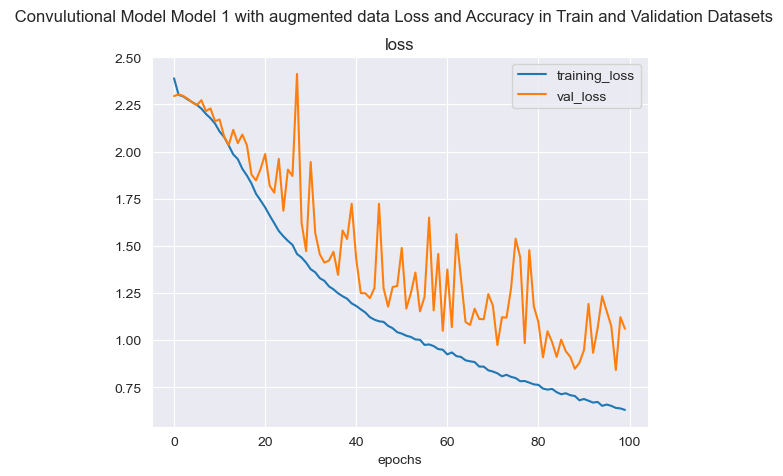

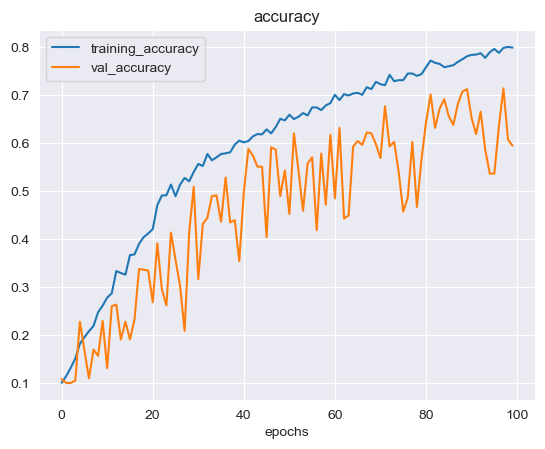

In [28]:
evaluate_conv_model(model1_1, "Model 1 with augmented data", X_train_aug, y_train_aug, X_test_aug, y_test_aug, epochs = epoch_number)

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0    0.91803   0.80000   0.85496        70
           1    0.88235   0.57692   0.69767        52
           2    0.39706   0.90000   0.55102        60
           3    0.54955   0.98387   0.70520        62
           4    0.89655   0.40000   0.55319        65
           5    0.94444   0.55738   0.70103        61
           6    0.59259   0.50794   0.54701        63
           7    0.73016   0.60526   0.66187        76
           8    0.88889   0.58182   0.70330        55
           9    0.61017   0.65455   0.63158        55

    accuracy                        0.65751       619
   macro avg    0.74098   0.65677   0.66068       619
weighted avg    0.74184   0.65751   0.66206       619



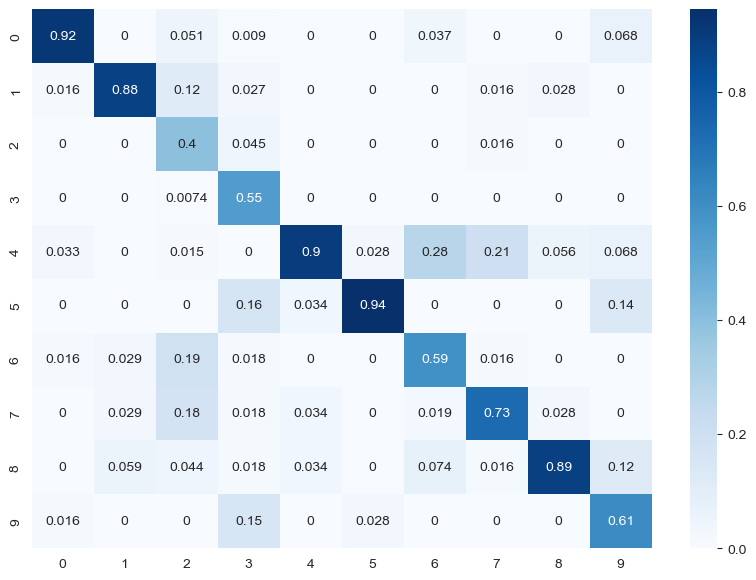

In [29]:
y_pred = model1_1.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,digits=5))

display_confusion_matrix(target_test, pred)

### Model 1 with augmented data and ADAM

In [30]:
model1_2=Sequential()
model1_2.add(layers.Conv2D(64, kernel_size=(3,3),
                       padding="same",
                       activation="relu", 
                       input_shape=(64, 64,1)))
model1_2.add(layers.MaxPooling2D((2,2)))

model1_2.add(layers.Flatten())
model1_2.add(layers.Dense(128, activation="relu"))
model1_2.add(layers.Dense(number_of_classes, activation="softmax"))


[INFO]:Convolutional Model Model 1 with augmented data + ADAM optimizer created...
[INFO]:Convolutional Model Model 1 with augmented data + ADAM optimizer compiled...
[INFO]:Convolutional Model Model 1 with augmented data + ADAM optimizer training....
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               8388736   
                                                                 


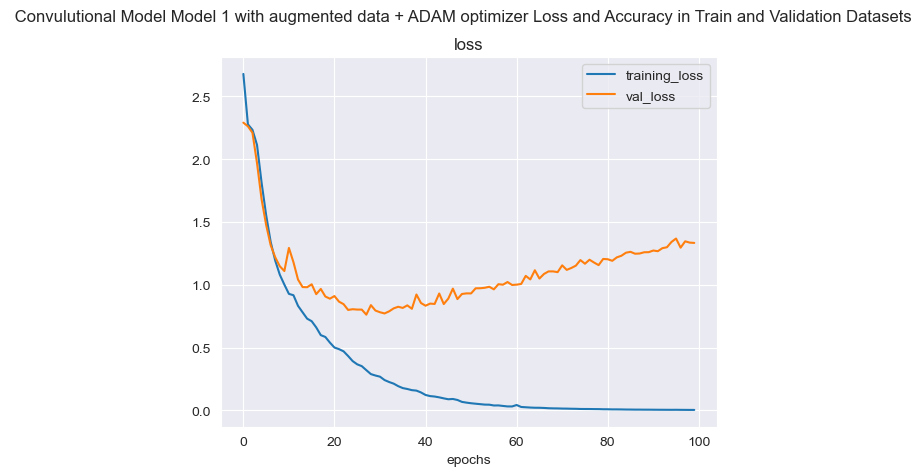

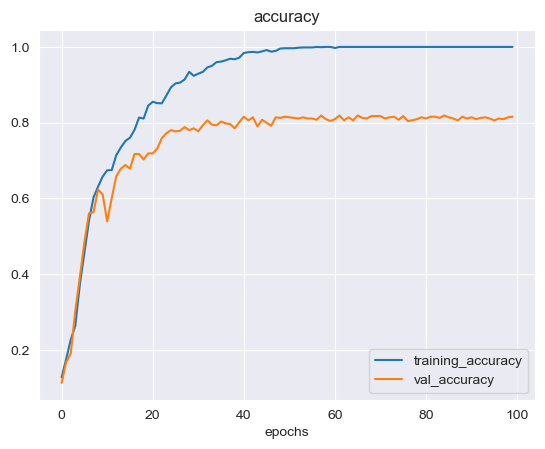

In [31]:
evaluate_conv_model(model1_2, "Model 1 with augmented data + ADAM optimizer", X_train_aug, y_train_aug, X_test_aug, y_test_aug, optimizer = optimizers.Adam(lr=0.001), epochs = epoch_number)

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0    0.97143   0.97143   0.97143        70
           1    0.96154   0.96154   0.96154        52
           2    0.90323   0.93333   0.91803        60
           3    0.96774   0.96774   0.96774        62
           4    0.93548   0.89231   0.91339        65
           5    0.96721   0.96721   0.96721        61
           6    0.90625   0.92063   0.91339        63
           7    0.93506   0.94737   0.94118        76
           8    0.94444   0.92727   0.93578        55
           9    0.96364   0.96364   0.96364        55

    accuracy                        0.94507       619
   macro avg    0.94560   0.94525   0.94533       619
weighted avg    0.94524   0.94507   0.94506       619



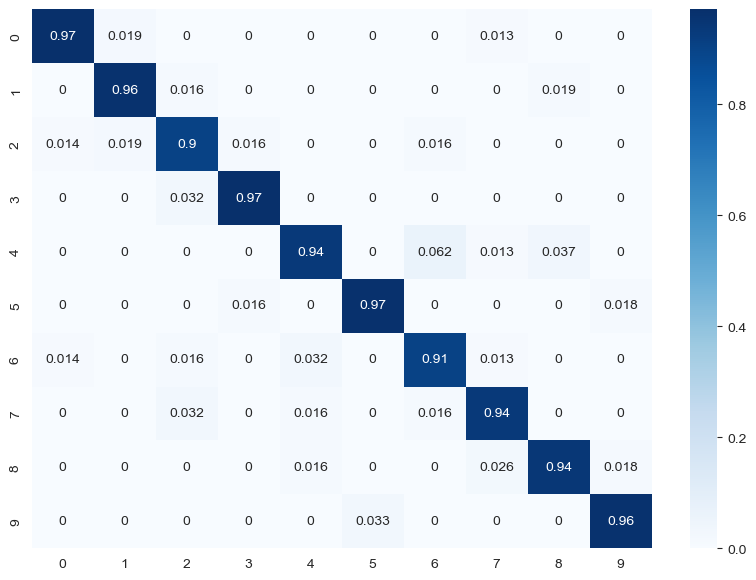

In [32]:
y_pred = model1_2.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,digits=5))

display_confusion_matrix(target_test, pred)

## Model 2

In [33]:
model2 = Sequential()
model2.add(layers.Convolution2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 1)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Convolution2D(64, (3, 3), activation='relu', padding="same"))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

[INFO]:Convolutional Model Model 2 with augmented data + ADAM optimizer created...
[INFO]:Convolutional Model Model 2 with augmented data + ADAM optimizer compiled...
[INFO]:Convolutional Model Model 2 with augmented data + ADAM optimizer training....
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             


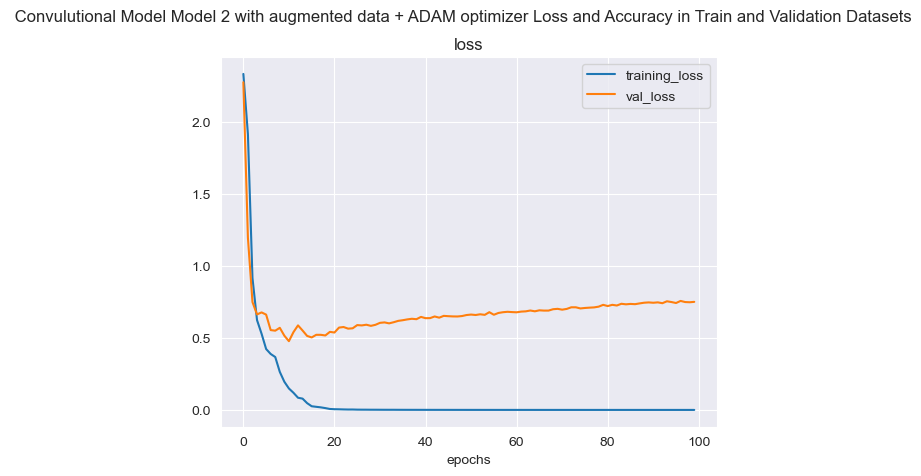

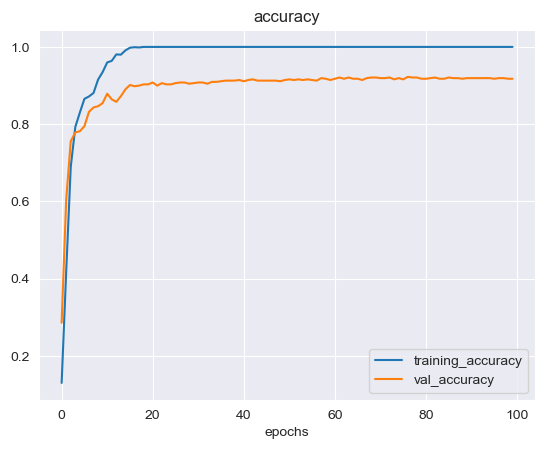

In [34]:
evaluate_conv_model(model2, "Model 2 with augmented data + ADAM optimizer", X_train_aug, y_train_aug, X_test_aug, y_test_aug, optimizer = optimizers.Adam(lr=0.001), epochs = epoch_number)

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        70
           1    1.00000   0.98077   0.99029        52
           2    1.00000   0.98333   0.99160        60
           3    1.00000   1.00000   1.00000        62
           4    0.98438   0.96923   0.97674        65
           5    0.98387   1.00000   0.99187        61
           6    0.96923   1.00000   0.98437        63
           7    0.98684   0.98684   0.98684        76
           8    0.96429   0.98182   0.97297        55
           9    1.00000   0.98182   0.99083        55

    accuracy                        0.98869       619
   macro avg    0.98886   0.98838   0.98855       619
weighted avg    0.98885   0.98869   0.98870       619



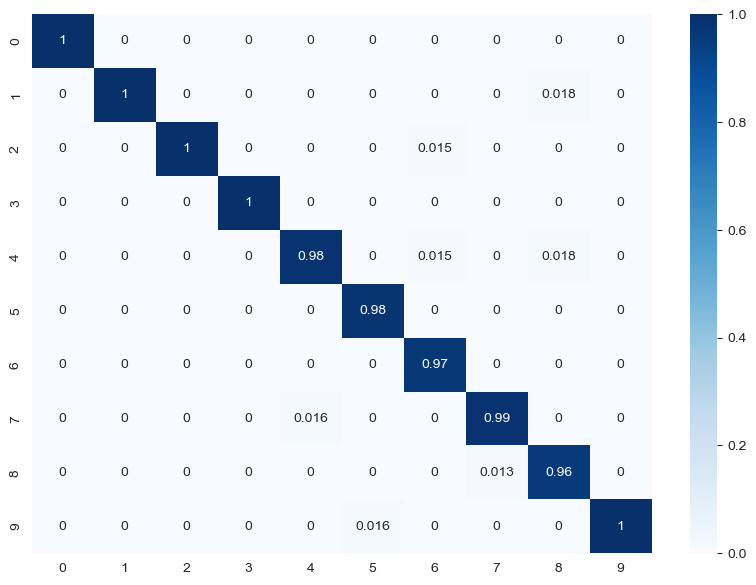

In [35]:
y_pred = model2.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,digits=5))

display_confusion_matrix(target_test, pred)

## Model 3

In [36]:
model3 = Sequential()
model3.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer created...
[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer compiled...
[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer training....
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             


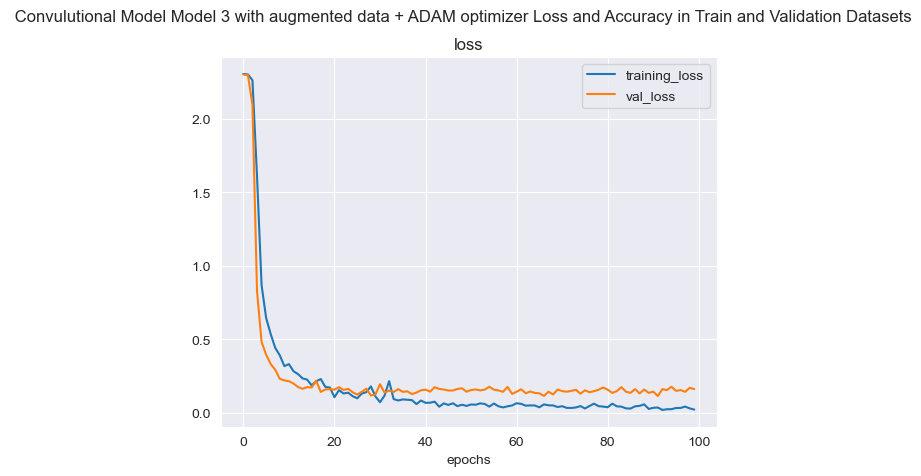

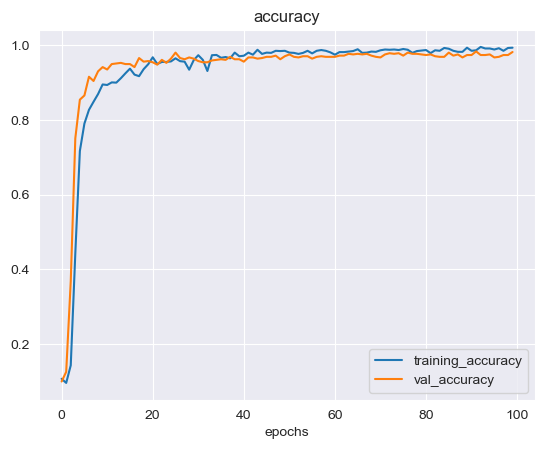

In [37]:
evaluate_conv_model(model3, "Model 3 with augmented data + ADAM optimizer", X_train_aug, y_train_aug, X_test_aug, y_test_aug, optimizer = optimizers.Adam(lr=0.001), epochs = epoch_number)

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0    1.00000   0.98571   0.99281        70
           1    1.00000   1.00000   1.00000        52
           2    1.00000   1.00000   1.00000        60
           3    1.00000   1.00000   1.00000        62
           4    1.00000   1.00000   1.00000        65
           5    0.98387   1.00000   0.99187        61
           6    1.00000   1.00000   1.00000        63
           7    1.00000   1.00000   1.00000        76
           8    0.98214   1.00000   0.99099        55
           9    1.00000   0.98182   0.99083        55

    accuracy                        0.99677       619
   macro avg    0.99660   0.99675   0.99665       619
weighted avg    0.99682   0.99677   0.99677       619



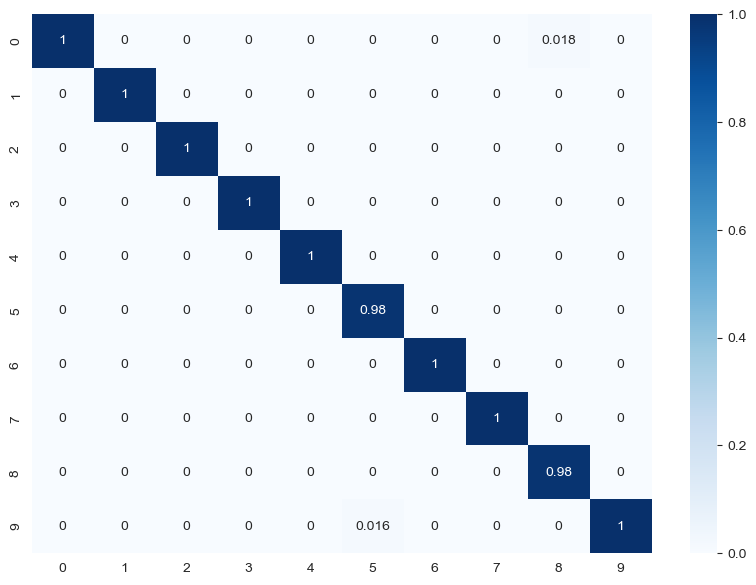

In [38]:
y_pred = model3.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,digits=5))

display_confusion_matrix(target_test, pred)

## Model 4

Batch normalization + additional dropout layers

In [39]:
model4 = Sequential()
model4.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.25))

model4.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.25))

model4.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.25))

model4.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.25))

model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.Dense(10, activation='softmax'))

[INFO]:Convolutional Model Model 4 with augmented data + ADAM optimizer created...
[INFO]:Convolutional Model Model 4 with augmented data + ADAM optimizer compiled...
[INFO]:Convolutional Model Model 4 with augmented data + ADAM optimizer training....
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 31, 31, 32)        0         


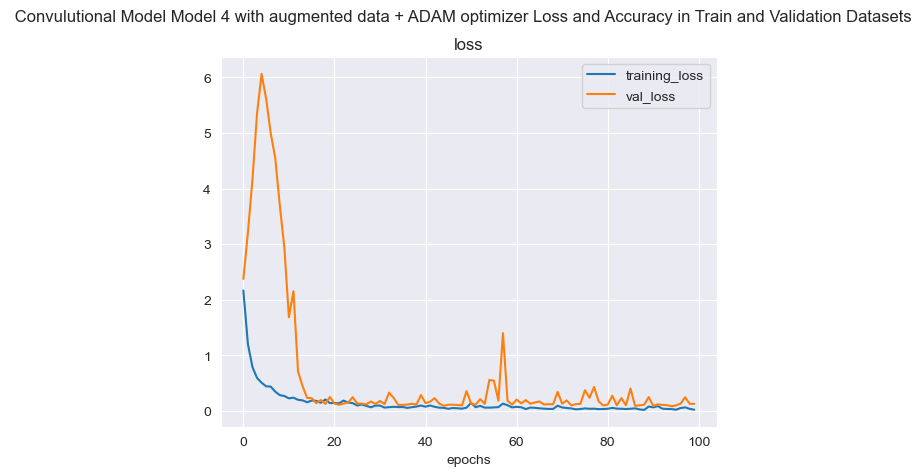

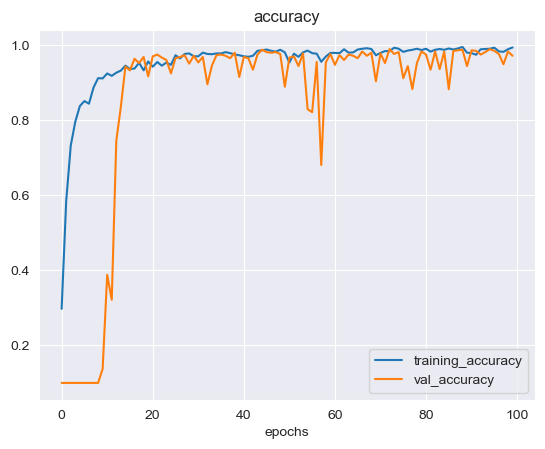

In [40]:
evaluate_conv_model(model4, "Model 4 with augmented data + ADAM optimizer", X_train_aug, y_train_aug, X_test_aug, y_test_aug, optimizer = optimizers.Adam(lr=0.001), epochs = epoch_number)

20/20 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        70
           1    0.98113   1.00000   0.99048        52
           2    0.98305   0.96667   0.97479        60
           3    0.98413   1.00000   0.99200        62
           4    1.00000   1.00000   1.00000        65
           5    1.00000   1.00000   1.00000        61
           6    1.00000   1.00000   1.00000        63
           7    1.00000   0.98684   0.99338        76
           8    1.00000   1.00000   1.00000        55
           9    1.00000   1.00000   1.00000        55

    accuracy                        0.99515       619
   macro avg    0.99483   0.99535   0.99506       619
weighted avg    0.99518   0.99515   0.99514       619



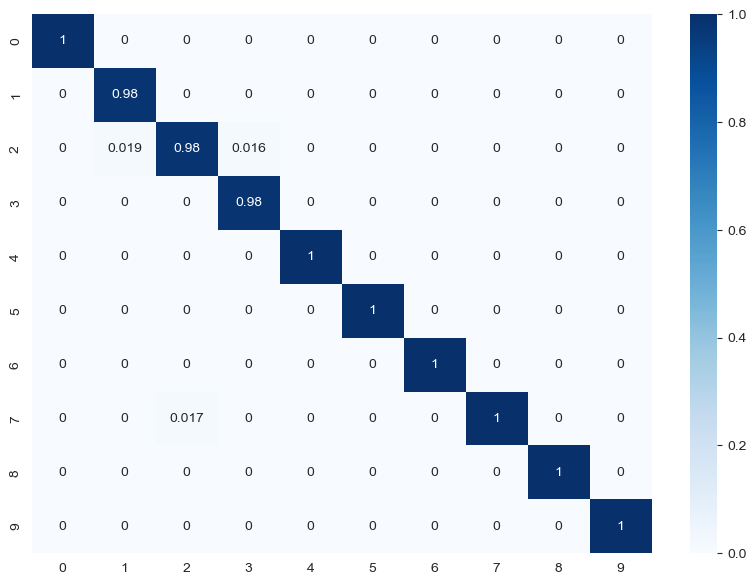

In [41]:
y_pred = model4.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,digits=5))

display_confusion_matrix(target_test, pred)

### Model 4 with callbacks

In [57]:
model4_1 = Sequential()
model4_1.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model4_1.add(layers.MaxPooling2D((2, 2)))
model4_1.add(layers.BatchNormalization())
model4_1.add(layers.Dropout(0.25))

model4_1.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model4_1.add(layers.MaxPooling2D((2, 2)))
model4_1.add(layers.BatchNormalization())
model4_1.add(layers.Dropout(0.25))

model4_1.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model4_1.add(layers.MaxPooling2D((2, 2)))
model4_1.add(layers.BatchNormalization())
model4_1.add(layers.Dropout(0.25))

model4_1.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model4_1.add(layers.MaxPooling2D((2, 2)))
model4_1.add(layers.BatchNormalization())
model4_1.add(layers.Dropout(0.25))

model4_1.add(layers.Flatten())
model4_1.add(layers.Dropout(0.5))
model4_1.add(layers.Dense(256, activation='relu'))
model4_1.add(layers.Dense(10, activation='softmax'))

In [58]:
earlyStopping = EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0001)
#callbacks = [reduce_lr]
callbacks = [earlyStopping, reduce_lr]

[INFO]:Convolutional Model Model 4 with augmented data + ADAM optimizer + callbacks created...
[INFO]:Convolutional Model Model 4 with augmented data + ADAM optimizer + callbacks compiled...
[INFO]:Convolutional Model Model 4 with augmented data + ADAM optimizer + callbacks training....
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 31, 31, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        

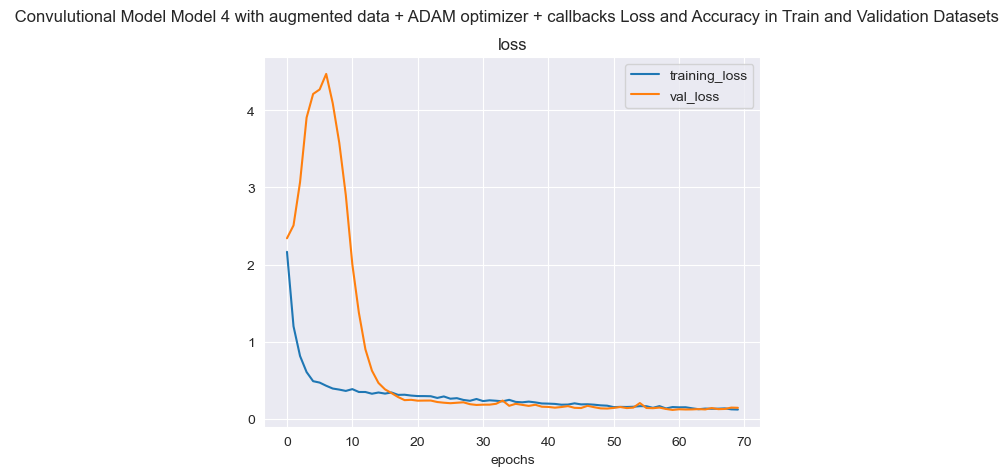

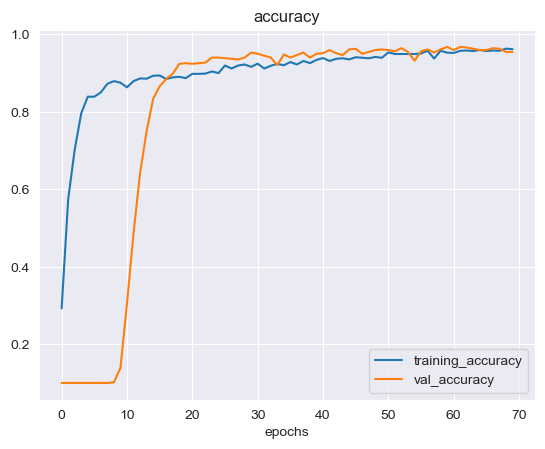

In [59]:
evaluate_conv_model(model4_1, "Model 4 with augmented data + ADAM optimizer + callbacks", X_train_aug, y_train_aug, X_test_aug, y_test_aug, optimizer = optimizers.Adam(lr=0.001), epochs = epoch_number, callbacks = callbacks)

20/20 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        70
           1    1.00000   1.00000   1.00000        52
           2    1.00000   0.98333   0.99160        60
           3    1.00000   1.00000   1.00000        62
           4    0.97015   1.00000   0.98485        65
           5    1.00000   1.00000   1.00000        61
           6    0.98413   0.98413   0.98413        63
           7    1.00000   1.00000   1.00000        76
           8    1.00000   0.96364   0.98148        55
           9    0.98214   1.00000   0.99099        55

    accuracy                        0.99354       619
   macro avg    0.99364   0.99311   0.99330       619
weighted avg    0.99366   0.99354   0.99353       619



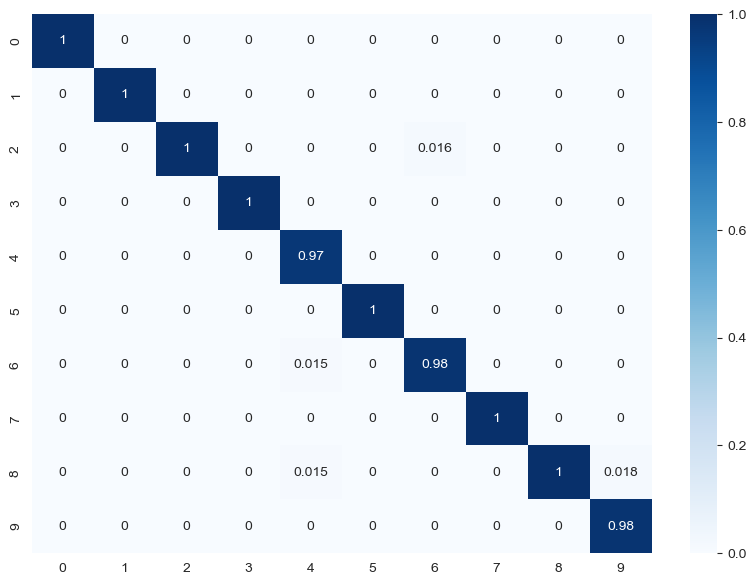

In [60]:
y_pred = model4_1.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,digits=5))

display_confusion_matrix(target_test, pred)

## Model 3 with callbacks

In [46]:
model3_1 = Sequential()
model3_1.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model3_1.add(layers.MaxPooling2D((2, 2)))

model3_1.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3_1.add(layers.MaxPooling2D((2, 2)))

model3_1.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3_1.add(layers.MaxPooling2D((2, 2)))

model3_1.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3_1.add(layers.MaxPooling2D((2, 2)))

model3_1.add(layers.Flatten())
model3_1.add(layers.Dropout(0.5))
model3_1.add(layers.Dense(256, activation='relu'))
model3_1.add(layers.Dense(10, activation='softmax'))

[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer created...
[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer compiled...
[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer training....
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            


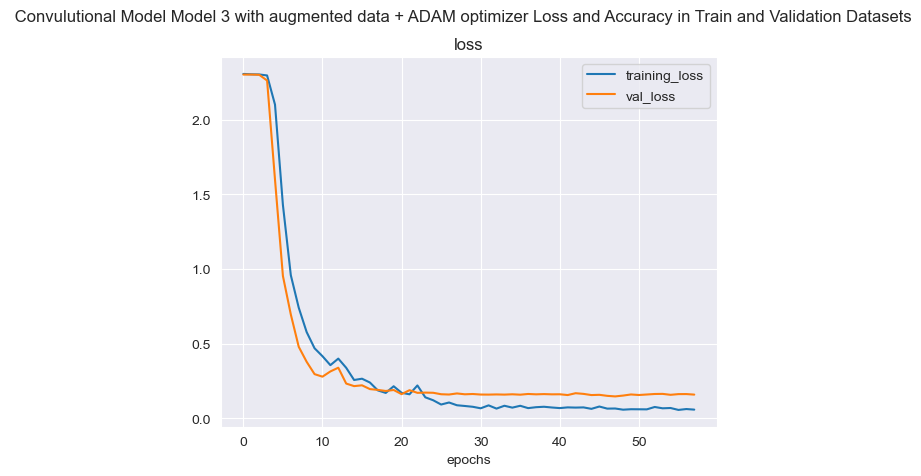

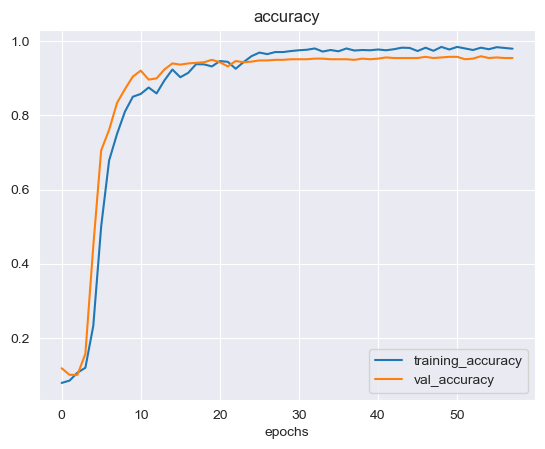

In [47]:
evaluate_conv_model(model3_1, "Model 3 with augmented data + ADAM optimizer", X_train_aug, y_train_aug, X_test_aug, y_test_aug, optimizer = optimizers.Adam(lr=0.001), epochs = epoch_number, callbacks = callbacks)

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0    1.00000   0.98571   0.99281        70
           1    0.98113   1.00000   0.99048        52
           2    0.98361   1.00000   0.99174        60
           3    1.00000   1.00000   1.00000        62
           4    0.98462   0.98462   0.98462        65
           5    1.00000   1.00000   1.00000        61
           6    1.00000   0.96825   0.98387        63
           7    1.00000   0.98684   0.99338        76
           8    0.96429   0.98182   0.97297        55
           9    0.98214   1.00000   0.99099        55

    accuracy                        0.99031       619
   macro avg    0.98958   0.99072   0.99008       619
weighted avg    0.99045   0.99031   0.99031       619



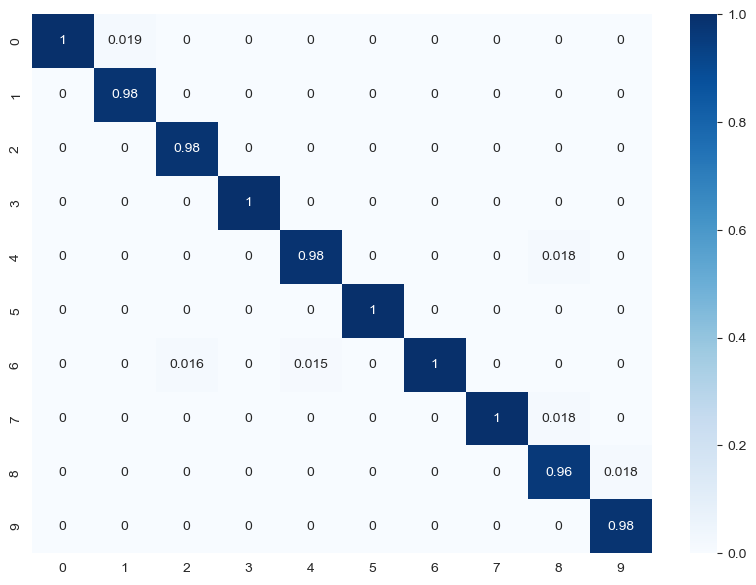

In [48]:
y_pred = model3_1.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,digits=5))

display_confusion_matrix(target_test, pred)

## Custom Loss Function

In [49]:
def custom_loss_function_mse(y_true, y_pred):
   squared_difference = tf.square(y_true - y_pred)
   return tf.reduce_mean(squared_difference, axis=-1)

In [50]:
model3_2 = Sequential()
model3_2.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model3_2.add(layers.MaxPooling2D((2, 2)))

model3_2.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3_2.add(layers.MaxPooling2D((2, 2)))

model3_2.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3_2.add(layers.MaxPooling2D((2, 2)))

model3_2.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3_2.add(layers.MaxPooling2D((2, 2)))

model3_2.add(layers.Flatten())
model3_2.add(layers.Dropout(0.5))
model3_2.add(layers.Dense(256, activation='relu'))
model3_2.add(layers.Dense(10, activation='softmax'))

[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer + custom loss created...
[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer + custom loss compiled...
[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer + custom loss training....
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                   

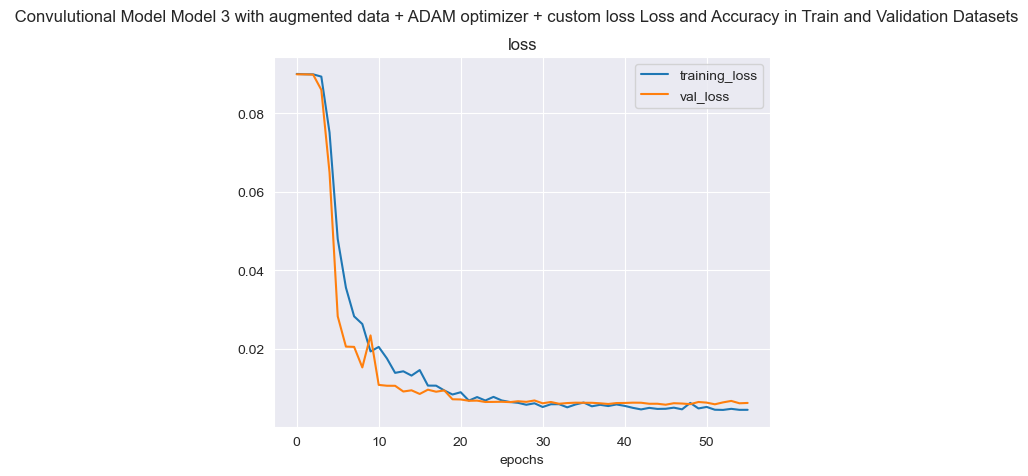

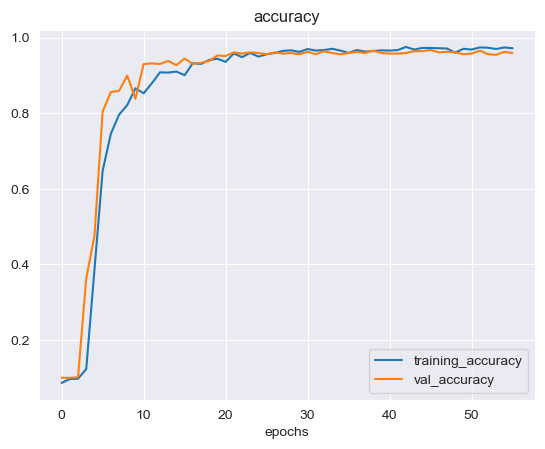

In [51]:
evaluate_conv_model(model3_2, "Model 3 with augmented data + ADAM optimizer + custom loss", X_train_aug, y_train_aug, X_test_aug, y_test_aug, loss = custom_loss_function_mse, optimizer = optimizers.Adam(lr=0.001), callbacks = callbacks, epochs = epoch_number)

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        70
           1    1.00000   1.00000   1.00000        52
           2    0.96774   1.00000   0.98361        60
           3    1.00000   1.00000   1.00000        62
           4    1.00000   0.98462   0.99225        65
           5    0.98387   1.00000   0.99187        61
           6    1.00000   0.95238   0.97561        63
           7    0.98684   0.98684   0.98684        76
           8    0.96429   0.98182   0.97297        55
           9    0.98182   0.98182   0.98182        55

    accuracy                        0.98869       619
   macro avg    0.98846   0.98875   0.98850       619
weighted avg    0.98888   0.98869   0.98868       619



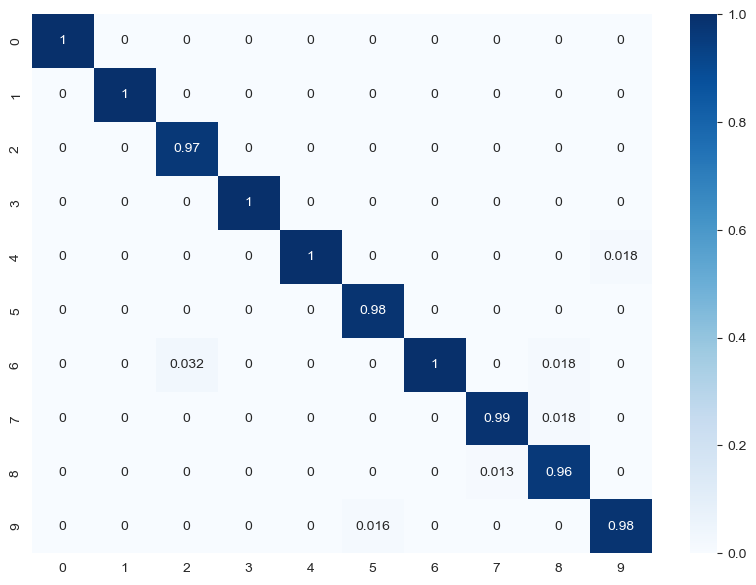

In [52]:
y_pred = model3_2.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,digits=5))

display_confusion_matrix(target_test, pred)

In [53]:
import keras.backend as kbe

def custom_loss_function_mae(y_true, y_pred):
            
    eval = kbe.abs(y_pred - y_true)
    eval = kbe.mean(eval, axis=-1)
        
    return eval

[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer created...
[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer compiled...
[INFO]:Convolutional Model Model 3 with augmented data + ADAM optimizer training....
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            


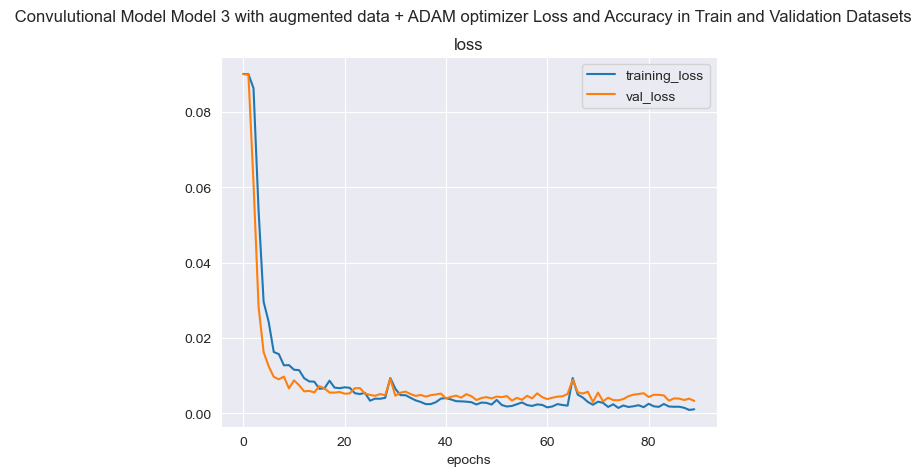

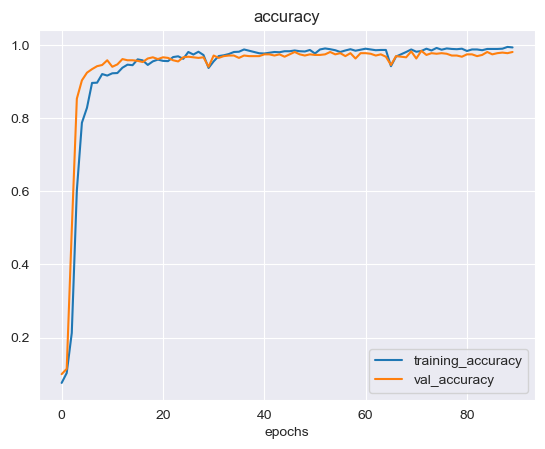

In [54]:
model3_3 = Sequential()
model3_3.add(layers.Convolution2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model3_3.add(layers.MaxPooling2D((2, 2)))

model3_3.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3_3.add(layers.MaxPooling2D((2, 2)))

model3_3.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3_3.add(layers.MaxPooling2D((2, 2)))

model3_3.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model3_3.add(layers.MaxPooling2D((2, 2)))

model3_3.add(layers.Flatten())
model3_3.add(layers.Dropout(0.5))
model3_3.add(layers.Dense(256, activation='relu'))
model3_3.add(layers.Dense(10, activation='softmax'))

evaluate_conv_model(model3_3, "Model 3 with augmented data + ADAM optimizer", X_train_aug, y_train_aug, X_test_aug, y_test_aug, loss = custom_loss_function_mse, optimizer = optimizers.Adam(lr=0.001), callbacks = [EarlyStopping(monitor = 'val_loss', patience=20, verbose = 1) ], epochs = epoch_number)

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000        70
           1    1.00000   1.00000   1.00000        52
           2    1.00000   1.00000   1.00000        60
           3    1.00000   1.00000   1.00000        62
           4    1.00000   1.00000   1.00000        65
           5    1.00000   1.00000   1.00000        61
           6    1.00000   1.00000   1.00000        63
           7    1.00000   1.00000   1.00000        76
           8    1.00000   0.98182   0.99083        55
           9    0.98214   1.00000   0.99099        55

    accuracy                        0.99838       619
   macro avg    0.99821   0.99818   0.99818       619
weighted avg    0.99841   0.99838   0.99838       619



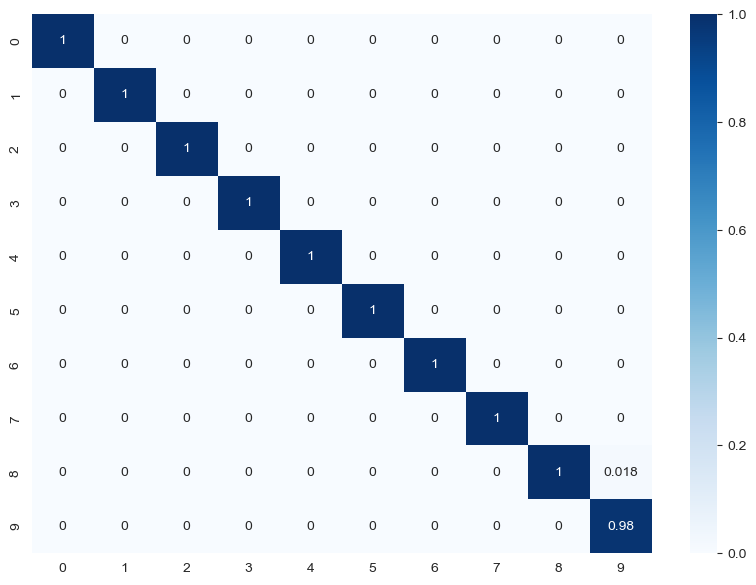

In [55]:
y_pred = model3_3.predict(X_test)
pred = np.argmax(y_pred,axis=1)
target_test = np.argmax(y_test,axis=1)

print(classification_report(target_test,pred,digits=5))

display_confusion_matrix(target_test, pred)